In [1]:
exp_no = 0

In [2]:
import os
import sys
import git
import pathlib

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/genkai-test


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [5]:
ALGO = "PPO"

In [6]:
env_id = "BreakoutNoFrameskip-v4"
exp_tag = "vanilla"
exp_name = f"{env_id}--{ALGO}--{exp_tag}"

In [7]:
logfolder_root = pathlib.Path(PROJ_ROOT_PATH / "sb3" / "notebook" / "logging")

# Directory to save all training statistics
log_dir = pathlib.Path(logfolder_root / exp_name)
os.makedirs(log_dir, exist_ok=True)

# Directory to save gif animations
gif_dir = pathlib.Path(log_dir / "gifs" / exp_name)
os.makedirs(gif_dir, exist_ok=True)

# Directory to save models
models_dir = pathlib.Path(PROJ_ROOT_PATH / "models" / exp_name)
os.makedirs(models_dir, exist_ok=True)

In [8]:
# The different number of processes that will be used
SEED = 0

NUM_ENVS = 32
TRAIN_STEPS = 1E6
N_EVAL_EPISODES = 100

In [9]:
for experiment in [exp_no]:
    print("-------")
    print(f"RUN: {experiment}")
    # Log directory for each run of the experiment
    run_log_dir = f"{log_dir}/run_{experiment}"
    
    # Make vector environment
    env = make_atari_env(env_id,
                         n_envs=NUM_ENVS,
                         monitor_dir=run_log_dir,
                         seed=SEED+experiment)
    
    # Frame-stacking with 4 frames
    env = VecFrameStack(env, n_stack=4)

    # Create RL model
    model = eval(ALGO)("CnnPolicy", env, verbose=0)

    # Train the agent
    model.learn(total_timesteps=TRAIN_STEPS, 
                progress_bar=True)

    # Save the final agent
    model.save(f"{models_dir}/{exp_name}-run_{experiment}")

-------
RUN: 0


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Output()

In [10]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

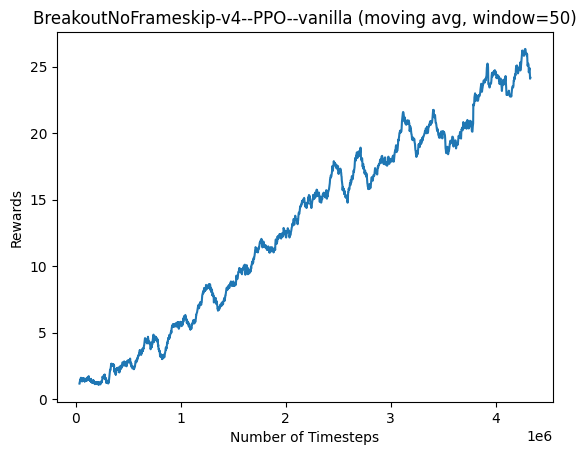

In [11]:
# Visualizing Results
WINDOW = 50

fig = plt.figure()
plt.xlabel("Number of Timesteps")
plt.ylabel("Rewards")
plt.title(exp_name + f" (moving avg, window={WINDOW})")

for experiment in [exp_no]:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "timesteps")
    y = moving_average(y, window=WINDOW)
    # Truncate x
    x = x[len(x) - len(y) :]    
    plt.plot(x, y)  
plt.show()   

In [12]:
# Evaluate Model
from stable_baselines3.common.evaluation import evaluate_policy
N_EVAL_EPISODES = 100

trained_model = eval(ALGO).load(f"{models_dir}/{exp_name}-run_{experiment}", verbose=1)
eval_env = make_atari_env(env_id,
                         n_envs=NUM_ENVS, 
                          seed=SEED+experiment+7)
eval_env = VecFrameStack(eval_env, n_stack=4)
trained_model.set_env(eval_env)

Wrapping the env in a VecTransposeImage.


In [13]:
mean_rew, mean_std=evaluate_policy(trained_model,
                                   trained_model.env, 
                                   n_eval_episodes=N_EVAL_EPISODES)

In [14]:
print(f"Reward: {mean_rew:.2f} \u00B1 {mean_std:.2f}")

Reward: 30.00 ± 6.82
